In [13]:
from dotenv import load_dotenv

load_dotenv()

True

#### Human-in-the-loop Revisión de nodos

In [1]:
import os
import uuid

import requests
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from typing_extensions import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.types import Command, interrupt

In [2]:
@tool
def weather_search(city: str):
    """tool que obtiene el clima de una ciudad"""

    WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

    resp = requests.get(
        f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{city}/today?unitGroup=metric&include=current&key={WEATHER_API_KEY}&contentType=json"
    )

    return resp.json()

In [3]:
model = ChatAnthropic(model_name="claude-3-5-sonnet-latest").bind_tools([
    weather_search
])

In [4]:
class State(MessagesState):
    """Simple state."""

In [5]:
def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}

def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    human_review = interrupt({
        "question": "Es correcto ?",
        "tool_call": tool_call,
    })

    review_action = human_review["action"]
    review_data = human_review.get("data")

    if review_action == "continue":
        return Command(goto="run_tool")

    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    "args": review_data,
                }
            ],
            "id": last_message.id,
        }
        
        return Command(goto="run_tool", update={"messages": [updated_message]})

    elif review_action == "feedback":
        # Se de agrega el feedback como ToolMessage
        # para preservar el orden correcto en el historial de mensajes
        # Los mensajes de IA con llamadas a tools deben ir seguidos de mensajes de llamadas a tools
        tool_message = {
            "role": "tool",
            "content": review_data,
            "name": tool_call["name"],
            "tool_call_id": tool_call["id"],
        }
        return Command(goto="call_llm", update={"messages": [tool_message]})

    
def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state["messages"][-1].tool_calls
    
    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        
        new_messages.append({
            "role": "tool",
            "name": tool_call["name"],
            "content": result,
            "tool_call_id": tool_call["id"],
        })
        
    return {"messages": new_messages}


def route_after_llm(state) -> Literal["__end__", "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"

In [6]:
builder = StateGraph(State)

builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)

builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

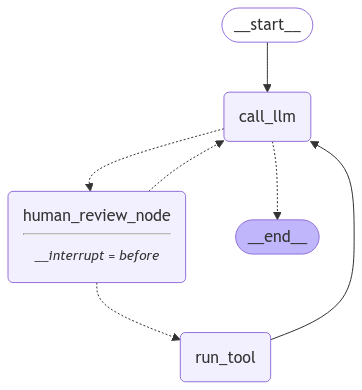

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### No review

In [8]:
initial_input = {"messages": [{"role": "user", "content": "Hola!"}]}

thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hola!
================================== Ai Message ==================================

¡Hola! ¿En qué puedo ayudarte? 

Veo que tengo acceso a una herramienta que permite consultar el clima de una ciudad. Si deseas saber el pronóstico del tiempo para alguna ciudad en particular, con gusto puedo ayudarte a consultarlo. ¿Hay alguna ciudad específica de la que quieras conocer el clima?


#### Aprobación de tool

In [9]:
initial_input = {"messages": [{"role": "user", "content": "Cuál es el clima en santiago de chile ?"}]}


thread = {"configurable": {"thread_id": uuid.uuid1()}}

# for event in graph.stream(initial_input, thread, stream_mode="updates"):
#     print(event)
#     print("\n")

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Cuál es el clima en santiago de chile ?
================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago de Chile.', 'type': 'text'}, {'id': 'toolu_01147YY5Nt63LJARWhUFen5Q', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01147YY5Nt63LJARWhUFen5Q)
 Call ID: toolu_01147YY5Nt63LJARWhUFen5Q
  Args:
    city: Santiago


In [10]:
print("Pendiente la ejecución!")
print(graph.get_state(thread).next)

Pendiente la ejecución!
('human_review_node',)


In [11]:
for event in graph.stream(
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago de Chile.', 'type': 'text'}, {'id': 'toolu_01147YY5Nt63LJARWhUFen5Q', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01147YY5Nt63LJARWhUFen5Q)
 Call ID: toolu_01147YY5Nt63LJARWhUFen5Q
  Args:
    city: Santiago
================================= Tool Message =================================
Name: weather_search

{'queryCost': 1, 'latitude': -33.4372, 'longitude': -70.65, 'resolvedAddress': 'Santiago, Región Metropolitana de Santiago, República de Chile', 'address': 'Santiago', 'timezone': 'America/Santiago', 'tzoffset': -3.0, 'days': [{'datetime': '2025-01-27', 'datetimeEpoch': 1737946800, 'tempmax': 32.0, 'tempmin': 14.0, 'temp': 23.3, 'feelslikemax': 30.2, 'feelslikemin': 14.0, 'feelslike': 22.7, 'dew': 8.8, 'humidity': 43.1, 'precip': 0.0, 'precipprob': 0.0, 'precipcover': 0.0, 'preciptype

#### Edit Tool Call

In [12]:
initial_input = {"messages": [{"role": "user", "content": "Cuál es el clima en stg ?"}]}

thread = {"configurable": {"thread_id": uuid.uuid4()}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Cuál es el clima en stg ?
================================== Ai Message ==================================

[{'text': 'Voy a buscar el clima para Santiago.', 'type': 'text'}, {'id': 'toolu_01SmvNwk1v8Xbt2fv4GL5Duk', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01SmvNwk1v8Xbt2fv4GL5Duk)
 Call ID: toolu_01SmvNwk1v8Xbt2fv4GL5Duk
  Args:
    city: Santiago


In [13]:
print("Pendiente la ejecución!")
print(graph.get_state(thread).next)

Pendiente la ejecución!
('human_review_node',)


In [14]:
for event in graph.stream(
    Command(resume={"action": "update", "data": {"city": "Santiago de chile"}}),
    thread,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Voy a buscar el clima para Santiago.', 'type': 'text'}, {'id': 'toolu_01SmvNwk1v8Xbt2fv4GL5Duk', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01SmvNwk1v8Xbt2fv4GL5Duk)
 Call ID: toolu_01SmvNwk1v8Xbt2fv4GL5Duk
  Args:
    city: Santiago
================================== Ai Message ==================================

[{'text': 'Voy a buscar el clima para Santiago.', 'type': 'text'}, {'id': 'toolu_01SmvNwk1v8Xbt2fv4GL5Duk', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01SmvNwk1v8Xbt2fv4GL5Duk)
 Call ID: toolu_01SmvNwk1v8Xbt2fv4GL5Duk
  Args:
    city: Santiago de chile
================================= Tool Message =================================
Name: weather_search

{'queryCost': 1, 'latitude': -33.4372, 'longitude': -70.65, 'resolvedAddress': 'Santiago, Re

#### Dar feedback a la llamada de una tool

In [15]:
thread = {"configurable": {"thread_id": "12"}}

In [16]:
initial_input = {"messages": [{"role": "user", "content": "Cuál es el clima en Santiago?"}]}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Cuál es el clima en Santiago ?
================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago.', 'type': 'text'}, {'id': 'toolu_01RbWoiRyxYpFowKytG5ZKtk', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01RbWoiRyxYpFowKytG5ZKtk)
 Call ID: toolu_01RbWoiRyxYpFowKytG5ZKtk
  Args:
    city: Santiago


In [17]:
print("Ejecución pendiente!")
print(graph.get_state(thread).next)

Ejecución pendiente!
('human_review_node',)


In [18]:
for event in graph.stream(
    Command(
        resume={
            "action": "feedback",
            "data": "El usuario requiere un cambios: el formato de la locación es <city, country>",
        }
    ),
    thread,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago.', 'type': 'text'}, {'id': 'toolu_01RbWoiRyxYpFowKytG5ZKtk', 'input': {'city': 'Santiago'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01RbWoiRyxYpFowKytG5ZKtk)
 Call ID: toolu_01RbWoiRyxYpFowKytG5ZKtk
  Args:
    city: Santiago
================================= Tool Message =================================
Name: weather_search

El usuario requiere un cambios: el formato de la locación es <city, country>
================================== Ai Message ==================================

Disculpe, necesito que especifique el país ya que hay varias ciudades llamadas Santiago. Por ejemplo, podría ser Santiago de Chile o Santiago de Cuba. ¿Podría indicarme específicamente qué Santiago desea consultar?


In [19]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
()


In [21]:
initial_input = {"messages": [{"role": "user", "content": "chile"}]}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

chile
================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago de Chile.', 'type': 'text'}, {'id': 'toolu_01TAFh6cXyquMSgyUKuvyf3h', 'input': {'city': 'Santiago, Chile'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01TAFh6cXyquMSgyUKuvyf3h)
 Call ID: toolu_01TAFh6cXyquMSgyUKuvyf3h
  Args:
    city: Santiago, Chile


In [22]:
for event in graph.stream(
    Command(resume={"action": "continue"}), thread, stream_mode="values"
):
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================

[{'text': 'Voy a consultar el clima en Santiago de Chile.', 'type': 'text'}, {'id': 'toolu_01TAFh6cXyquMSgyUKuvyf3h', 'input': {'city': 'Santiago, Chile'}, 'name': 'weather_search', 'type': 'tool_use'}]
Tool Calls:
  weather_search (toolu_01TAFh6cXyquMSgyUKuvyf3h)
 Call ID: toolu_01TAFh6cXyquMSgyUKuvyf3h
  Args:
    city: Santiago, Chile
================================= Tool Message =================================
Name: weather_search

{'queryCost': 1, 'latitude': -33.4372, 'longitude': -70.65, 'resolvedAddress': 'Santiago, Región Metropolitana de Santiago, República de Chile', 'address': 'Santiago, Chile', 'timezone': 'America/Santiago', 'tzoffset': -3.0, 'days': [{'datetime': '2025-01-27', 'datetimeEpoch': 1737946800, 'tempmax': 32.0, 'tempmin': 14.0, 'temp': 23.3, 'feelslikemax': 30.2, 'feelslikemin': 14.0, 'feelslike': 22.7, 'dew': 8.8, 'humidity': 43.1, 'precip': 0.0, 'precipprob': 0.0, 'precipcov